Name : ธีรพงค์ ศันสนียวรรธน์ <br>
Date : 23 May 2564 <br>
Description : <br>
<br> <br>

เป็นส่วนหนึ่งของวิชา BADS 7105 Customer Analytics <br>
อาจารย์ผู้สอน ดร. ธนชาตย์ ฤทธิ์บำรุง <br> <br>
สาขาวิชาการวิเคราะธ์ธุรกิจและวิทยาการข้อมูล DS รุ่นที่ 5 <br>
คณะสถิติประยุกต์ <br>
สถาบันบัณฑิตพัฒนบริหารศาสตร์ (นิด้า) NIDA <br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

## Load and View Raw Data

In [2]:
supermarket_df = pd.read_csv('./data/Supermarket Data.csv')
supermarket_df['SHOP_DATE'] = pd.to_datetime(supermarket_df.SHOP_DATE, format='%Y%m%d')
print(supermarket_df.shape)
supermarket_df.head()

(956574, 22)


,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200732,2007-10-05,6,17,3,6.75,PRD0900001,CL00072,DEP00021,G00007,...,UM,YF,994107800547472,L,MM,Top Up,Grocery,STORE00001,LS,E02
1,200733,2007-10-10,4,20,3,6.75,PRD0900001,CL00072,DEP00021,G00007,...,MM,OF,994107900512001,L,MM,Full Shop,Fresh,STORE00001,LS,E02
2,200741,2007-12-09,1,11,1,2.25,PRD0900001,CL00072,DEP00021,G00007,...,MM,YF,994108700468327,L,MM,Full Shop,Grocery,STORE00001,LS,E02
3,200731,2007-09-29,7,17,1,2.25,PRD0900001,CL00072,DEP00021,G00007,...,LA,OF,994107700237811,L,LA,Full Shop,Mixed,STORE00001,LS,E02
4,200737,2007-11-10,7,14,3,6.75,PRD0900001,CL00072,DEP00021,G00007,...,NaN,NaN,994108300002212,L,MM,Full Shop,Fresh,STORE00001,LS,E02


## Load and View Customer Single Data
ชุดข้อมูลนี้ได้มาจากการนำเอาชุดข้อมูลข้างต้นไปประมวลผลโดยใช้ Big Query

In [3]:
customer_df = pd.read_csv('./data/customer_single_view.csv')
print(customer_df.shape)
customer_df.head()

(6100, 25)


,cust_code,total_visit,total_spend,cust_week,recency,weekly_frequency,weekly_monetory,avg_bastket_size,basket_sen_la,basket_sen_mm,...,customer_sen_xx,basket_type_ss,basket_type_tu,basket_type_fs,basket_type_xx,basket_dominant_fr,basket_dominant_gr,basket_dominant_mi,basket_dominant_nf,basket_dominant_xx
0,CUST0000009685,1,0.46,64,439,0.015625,0.007187,0.46,0,1,...,0,1,0,0,0,0,1,0,0,0
1,CUST0000133268,1,5.97,64,438,0.015625,0.093281,5.97,0,0,...,0,1,0,0,0,1,0,0,0,0
2,CUST0000229808,1,3.47,64,437,0.015625,0.054219,3.47,1,0,...,0,1,0,0,0,1,0,0,0,0
3,CUST0000889939,1,4.74,64,440,0.015625,0.074063,4.74,0,1,...,0,1,0,0,0,1,0,0,0,0
4,CUST0000989305,1,0.61,64,439,0.015625,0.009531,0.61,0,1,...,0,1,0,0,0,0,0,0,0,0


## EDA
ซึ่งพบว่าข้อมูลการ Visit เพียงแค่ 1 มีปริมาณข้อมูลเป็นครึ่งหนึ่งของข้อมูลที่มี Visit มากกว่า 1 ดังนั้นจะทำการแยกวิเคราะห์ขอมูลเป็น 2 ชุดคือ Visit เพียงครั้งเดียว กับ Visit มากกว่า 1 ครั้ง

In [4]:
df = customer_df.groupby(['total_visit']).agg(
    {'cust_code': pd.Series.nunique
    }).reset_index().rename(columns={'cust_code':'Amount Customer'})
df.head()

,total_visit,Amount Customer
0,1,2025
1,2,891
2,3,471
3,4,305
4,5,195


### Single Visit Customer

In [5]:
one_visit_df = customer_df[customer_df['total_visit']==1]
print("Dimension :",one_visit_df.shape)
one_visit_df.head()

Dimension : (2025, 25)


,cust_code,total_visit,total_spend,cust_week,recency,weekly_frequency,weekly_monetory,avg_bastket_size,basket_sen_la,basket_sen_mm,...,customer_sen_xx,basket_type_ss,basket_type_tu,basket_type_fs,basket_type_xx,basket_dominant_fr,basket_dominant_gr,basket_dominant_mi,basket_dominant_nf,basket_dominant_xx
0,CUST0000009685,1,0.46,64,439,0.015625,0.007187,0.46,0,1,...,0,1,0,0,0,0,1,0,0,0
1,CUST0000133268,1,5.97,64,438,0.015625,0.093281,5.97,0,0,...,0,1,0,0,0,1,0,0,0,0
2,CUST0000229808,1,3.47,64,437,0.015625,0.054219,3.47,1,0,...,0,1,0,0,0,1,0,0,0,0
3,CUST0000889939,1,4.74,64,440,0.015625,0.074063,4.74,0,1,...,0,1,0,0,0,1,0,0,0,0
4,CUST0000989305,1,0.61,64,439,0.015625,0.009531,0.61,0,1,...,0,1,0,0,0,0,0,0,0,0


### More Visit Customer

In [6]:
more_visit_df = customer_df[customer_df['total_visit']>1]
print("Dimension :",more_visit_df.shape)
more_visit_df.head()

Dimension : (4075, 25)


,cust_code,total_visit,total_spend,cust_week,recency,weekly_frequency,weekly_monetory,avg_bastket_size,basket_sen_la,basket_sen_mm,...,customer_sen_xx,basket_type_ss,basket_type_tu,basket_type_fs,basket_type_xx,basket_dominant_fr,basket_dominant_gr,basket_dominant_mi,basket_dominant_nf,basket_dominant_xx
2025,CUST0000485460,2,2.42,1,1,2.00000,2.420000,1.21,0,2,...,0,2,0,0,0,0,2,0,0,0
2026,CUST0000090124,2,6.42,1,1,2.00000,6.420000,3.21,0,2,...,0,2,0,0,0,0,2,0,0,0
2027,CUST0000514798,2,35.70,1,1,2.00000,35.700000,17.85,2,0,...,0,0,2,0,0,0,0,2,0,0
2028,CUST0000446520,2,23.92,64,440,0.03125,0.373750,11.96,0,2,...,0,1,0,0,1,0,1,0,0,1
2029,CUST0000197843,2,14.34,64,439,0.03125,0.224062,7.17,0,0,...,0,2,0,0,0,1,1,0,0,0


In [7]:
one_visit_predict_df = one_visit_df[['recency','weekly_frequency','weekly_monetory','avg_bastket_size']].copy()
one_visit_predict_df.head()

,recency,weekly_frequency,weekly_monetory,avg_bastket_size
0,439,0.015625,0.007187,0.46
1,438,0.015625,0.093281,5.97
2,437,0.015625,0.054219,3.47
3,440,0.015625,0.074063,4.74
4,439,0.015625,0.009531,0.61


### หาจำนวน Customer ของ single visit customer ด้วย Elbow Method
ผลที่ได้คือ จำนวนกลุ่มที่เหมาะสมที่สุดคือ 4 กลุ่ม

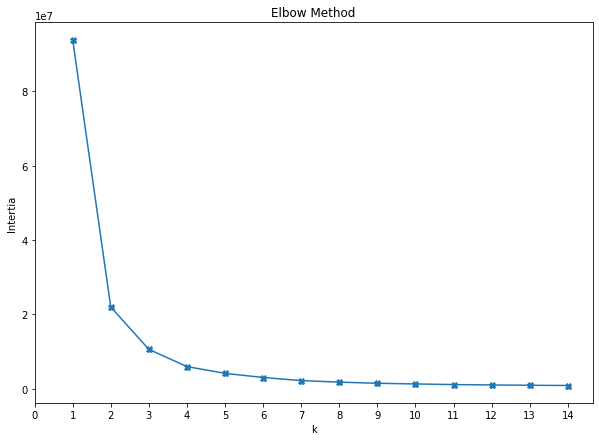

In [8]:
# Elbow Method 
intertia= []
amount_cluster_range = range(1,15)
for k in amount_cluster_range:
    km_model = KMeans(n_clusters=k)
    km_model.fit(one_visit_predict_df)
    intertia.append(km_model.inertia_)

plt.figure(figsize=(10,7))
plt.plot(amount_cluster_range,intertia,marker="X")
plt.xlabel('k')
plt.xticks(np.arange(15))
plt.ylabel('Intertia')
plt.title('Elbow Method')
plt.show()

In [9]:
more_visit_predict_df = more_visit_df[['recency','weekly_frequency','weekly_monetory','avg_bastket_size']].copy()
more_visit_predict_df.head()

,recency,weekly_frequency,weekly_monetory,avg_bastket_size
2025,1,2.00000,2.420000,1.21
2026,1,2.00000,6.420000,3.21
2027,1,2.00000,35.700000,17.85
2028,440,0.03125,0.373750,11.96
2029,439,0.03125,0.224062,7.17


### หาจำนวน Cluster ของ more visit customer ด้วย Elbow Method
ผลที่ได้คือ จำนวนกลุ่มที่เหมาะสมที่สุดคือ 4 กลุ่ม

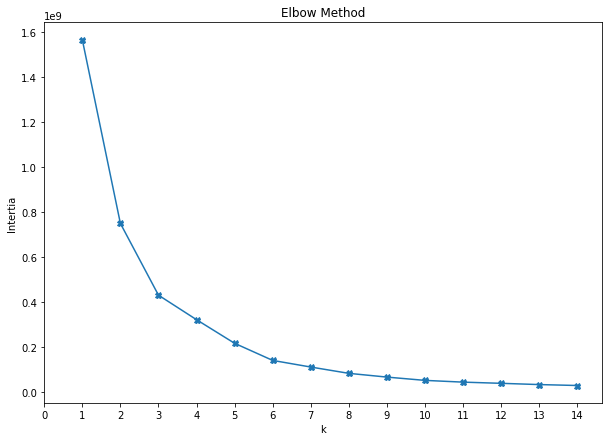

In [10]:
# Elbow Method 
intertia= []
amount_cluster_range = range(1,15)
for k in amount_cluster_range:
    km_model = KMeans(n_clusters=k)
    km_model.fit(more_visit_predict_df)
    intertia.append(km_model.inertia_)

plt.figure(figsize=(10,7))
plt.plot(amount_cluster_range,intertia,marker="X")
plt.xlabel('k')
plt.xticks(np.arange(15))
plt.ylabel('Intertia')
plt.title('Elbow Method')
plt.show()

In [11]:
NUM_CLUSTER = 4
km_model = KMeans(n_clusters=NUM_CLUSTER,random_state=400)
km_model.fit(one_visit_predict_df)
cluster = km_model.predict(one_visit_predict_df)

one_visit_predict_df['cluster'] = cluster
one_visit_predict_df.head()

,recency,weekly_frequency,weekly_monetory,avg_bastket_size,cluster
0,439,0.015625,0.007187,0.46,2
1,438,0.015625,0.093281,5.97,2
2,437,0.015625,0.054219,3.47,2
3,440,0.015625,0.074063,4.74,2
4,439,0.015625,0.009531,0.61,2


In [12]:
one_visit_predict_df.groupby('cluster').describe().T

cluster                          0           1           2           3
recency          count  469.000000  471.000000  509.000000  576.000000
                 mean   174.622601  537.214437  345.485265  724.307292
                 std     51.242098   54.772670   50.127223   53.166295
                 min     92.000000  442.000000  261.000000  632.000000
                 25%    128.000000  491.000000  305.000000  681.000000
                 50%    179.000000  539.000000  343.000000  716.500000
                 75%    220.000000  584.000000  386.000000  770.250000
                 max    260.000000  630.000000  441.000000  819.000000
weekly_frequency count  469.000000  471.000000  509.000000  576.000000
                 mean     0.041521    0.012947    0.020153    0.009598
                 std      0.012612    0.001318    0.002870    0.000693
                 min      0.026316    0.010989    0.015625    0.008475
                 25%      0.030303    0.011765    0.017857    0.009009
                 50%      0.037037    0.012821    0.020000    0.009615
                 75%      0.050000    0.014085    0.022222    0.010101
                 max      0.071429    0.015625    0.025641    0.010870
weekly_monetory  count  469.000000  471.000000  509.000000  576.000000
                 mean     0.337152    0.107635    0.183712    0.077036
                 std      0.638195    0.192258    0.349804    0.122201
                 min      0.000278    0.000115    0.000179    0.000102
                 25%      0.040588    0.013397    0.021500    0.011304
                 50%      0.105000    0.035072    0.054222    0.028132
                 75%      0.316000    0.116478    0.181017    0.092428
                 max      4.964000    2.246543    3.682889    1.252243
avg_bastket_size count  469.000000  471.000000  509.000000  576.000000
                 mean     7.987441    8.451868    9.073595    8.034566
                 std     14.040304   15.479303   16.938091   12.801685
                 min      0.010000    0.010000    0.010000    0.010000
                 25%      0.980000    1.030000    1.020000    1.170000
                 50%      2.590000    2.590000    2.830000    2.920000
                 75%      8.390000    9.055000    9.350000    9.285000
                 max    104.290000  181.970000  165.730000  133.990000

In [13]:
NUM_CLUSTER = 4
km_model = KMeans(n_clusters=NUM_CLUSTER,random_state=400)
km_model.fit(more_visit_predict_df)
cluster = km_model.predict(more_visit_predict_df)

more_visit_predict_df['cluster'] = cluster
more_visit_predict_df.head()

,recency,weekly_frequency,weekly_monetory,avg_bastket_size,cluster
2025,1,2.00000,2.420000,1.21,0
2026,1,2.00000,6.420000,3.21,0
2027,1,2.00000,35.700000,17.85,0
2028,440,0.03125,0.373750,11.96,3
2029,439,0.03125,0.224062,7.17,3


In [14]:
more_visit_predict_df.groupby('cluster').describe().T

cluster                           0            1             2           3
recency          count  3005.000000   251.000000     22.000000  797.000000
                 mean     61.242596     4.143426      1.000000  471.457967
                 std      63.159085     3.339962      0.000000  148.997015
                 min       1.000000     1.000000      1.000000  260.000000
                 25%      14.000000     1.500000      1.000000  342.000000
                 50%      39.000000     3.000000      1.000000  447.000000
                 75%      85.000000     5.500000      1.000000  586.000000
                 max     260.000000    19.000000      1.000000  818.000000
weekly_frequency count  3005.000000   251.000000     22.000000  797.000000
                 mean      7.799115   105.443227    351.227273    0.053359
                 std      17.374872    76.369493    167.839757    0.041891
                 min       0.052632    14.666667     98.000000    0.016949
                 25%       0.307692    54.250000    209.250000    0.028169
                 50%       1.200000    79.000000    311.000000    0.040000
                 75%       5.800000   136.250000    517.000000    0.065217
                 max     182.000000   444.000000    624.000000    0.410256
weekly_monetory  count  3005.000000   251.000000     22.000000  797.000000
                 mean     72.638315  1441.351697   5703.765909    0.519702
                 std     140.559230   600.369366   2557.326243    0.869494
                 min       0.000526   759.596667   3748.340000    0.000317
                 25%       1.467500   963.935000   4126.742500    0.080128
                 50%       9.000000  1218.765000   4833.980000    0.218679
                 75%      63.295000  1811.777500   5994.510000    0.558298
                 max     753.325000  3491.230000  14998.110000    8.694878
avg_bastket_size count  3005.000000   251.000000     22.000000  797.000000
                 mean     10.830825    18.857658     19.299721    8.751275
                 std      12.652772    11.238012      9.508963    9.733489
                 min       0.010000     3.419640      8.046234    0.010000
                 25%       3.140000    10.390510     11.753182    2.115000
                 50%       7.076250    16.914430     16.748604    4.935714
                 75%      14.456429    24.226351     25.207377   12.308333
                 max     306.970000    63.061667     40.872755   76.450000

In [15]:
one_visit_final_df = pd.DataFrame()
one_visit_final_df['cust_code'] = one_visit_df['cust_code']
one_visit_final_df['cluster'] = one_visit_predict_df['cluster']
one_visit_final_df = one_visit_final_df.merge(customer_df,how='left',on=['cust_code'])

print("Dimension : ",one_visit_final_df.shape)
one_visit_final_df.head()

Dimension :  (2025, 26)


,cust_code,cluster,total_visit,total_spend,cust_week,recency,weekly_frequency,weekly_monetory,avg_bastket_size,basket_sen_la,...,customer_sen_xx,basket_type_ss,basket_type_tu,basket_type_fs,basket_type_xx,basket_dominant_fr,basket_dominant_gr,basket_dominant_mi,basket_dominant_nf,basket_dominant_xx
0,CUST0000009685,2,1,0.46,64,439,0.015625,0.007187,0.46,0,...,0,1,0,0,0,0,1,0,0,0
1,CUST0000133268,2,1,5.97,64,438,0.015625,0.093281,5.97,0,...,0,1,0,0,0,1,0,0,0,0
2,CUST0000229808,2,1,3.47,64,437,0.015625,0.054219,3.47,1,...,0,1,0,0,0,1,0,0,0,0
3,CUST0000889939,2,1,4.74,64,440,0.015625,0.074063,4.74,0,...,0,1,0,0,0,1,0,0,0,0
4,CUST0000989305,2,1,0.61,64,439,0.015625,0.009531,0.61,0,...,0,1,0,0,0,0,0,0,0,0


In [16]:
more_visit_final_df = pd.DataFrame()
more_visit_final_df['cust_code'] = more_visit_df['cust_code']
more_visit_final_df['cluster'] = more_visit_predict_df['cluster']
more_visit_final_df = more_visit_final_df.merge(customer_df,how='left',on=['cust_code'])

print("Dimension : ",more_visit_final_df.shape)
more_visit_final_df.head()

Dimension :  (4075, 26)


,cust_code,cluster,total_visit,total_spend,cust_week,recency,weekly_frequency,weekly_monetory,avg_bastket_size,basket_sen_la,...,customer_sen_xx,basket_type_ss,basket_type_tu,basket_type_fs,basket_type_xx,basket_dominant_fr,basket_dominant_gr,basket_dominant_mi,basket_dominant_nf,basket_dominant_xx
0,CUST0000485460,0,2,2.42,1,1,2.00000,2.420000,1.21,0,...,0,2,0,0,0,0,2,0,0,0
1,CUST0000090124,0,2,6.42,1,1,2.00000,6.420000,3.21,0,...,0,2,0,0,0,0,2,0,0,0
2,CUST0000514798,0,2,35.70,1,1,2.00000,35.700000,17.85,2,...,0,0,2,0,0,0,0,2,0,0
3,CUST0000446520,3,2,23.92,64,440,0.03125,0.373750,11.96,0,...,0,1,0,0,1,0,1,0,0,1
4,CUST0000197843,3,2,14.34,64,439,0.03125,0.224062,7.17,0,...,0,2,0,0,0,1,1,0,0,0


In [17]:
final_sumpermarket_df = one_visit_final_df.append(more_visit_final_df, ignore_index=True)
print("Dimension : ",final_sumpermarket_df.shape)
final_sumpermarket_df.head()

Dimension :  (6100, 26)


,cust_code,cluster,total_visit,total_spend,cust_week,recency,weekly_frequency,weekly_monetory,avg_bastket_size,basket_sen_la,...,customer_sen_xx,basket_type_ss,basket_type_tu,basket_type_fs,basket_type_xx,basket_dominant_fr,basket_dominant_gr,basket_dominant_mi,basket_dominant_nf,basket_dominant_xx
0,CUST0000009685,2,1,0.46,64,439,0.015625,0.007187,0.46,0,...,0,1,0,0,0,0,1,0,0,0
1,CUST0000133268,2,1,5.97,64,438,0.015625,0.093281,5.97,0,...,0,1,0,0,0,1,0,0,0,0
2,CUST0000229808,2,1,3.47,64,437,0.015625,0.054219,3.47,1,...,0,1,0,0,0,1,0,0,0,0
3,CUST0000889939,2,1,4.74,64,440,0.015625,0.074063,4.74,0,...,0,1,0,0,0,1,0,0,0,0
4,CUST0000989305,2,1,0.61,64,439,0.015625,0.009531,0.61,0,...,0,1,0,0,0,0,0,0,0,0


In [18]:
final_sumpermarket_df.to_excel("./data/final_sumpermarket.xlsx")